In [10]:
from os.path import join as opj
from nipype.interfaces.spm import Normalize12
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.misc import Gunzip
from nipype import Workflow, Node

In [11]:
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/opt/spm12')

In [12]:
experiment_dir = '/data/EFAT/EFAT_output/PT'
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers 
subject_list = ['001', '003', '004']
                #, '005', '006', '007', 
                #'008', '009', '010', '013', '014', '015', 
                #'016', '019', '021', '022', '024', '025', 
                #'026', '027', '029', '030', '032', '034', 
                #'036', '037', '038', '039', '041', '042', 
                #'045', '046', '050', '051', '052', '054', 
                #'055', '056', '058', '059']

# task name
task_name = "EFAT"

# Smoothing widths used during preprocessing
fwhm = [8]

un_list = ['01', '02']

# Template to normalize to
template = '/opt/spm12/tpm/TPM.nii'

In [13]:
# Gunzip - unzip the anatomical image
gunzip = Node(Gunzip(), name="gunzip")

# Normalize - normalizes functional and structural images to the MNI template
normalize = Node(Normalize12(jobtype='estwrite',
                             tpm=template,
                             write_voxel_sizes=[1, 1, 1]),
                 name="normalize")

In [14]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'fwhm_id', 'un_num']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('fwhm_id', fwhm),
                        ('un_num', un_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
templates = {'func': opj(output_dir, 'preproc',
                        'sub-{subject_id}/task-EFAT', 'run-{un_num}', 
                        'fwhm-8_ssub-{subject_id}_task-EFAT_run-{un_num}_bold.nii'),
             'anat': opj('fmriprep','sub-{subject_id}/', 'anat',
                         'sub-{subject_id}_T1w_preproc.nii.gz')}

selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-'),
                 ('_un_num_', '/run-')]
subjFolders = [('_fwhm_id_%ssub-%s' % (f, sub), 'sub-%s_fwhm%s' % (sub, f))
               for f in fwhm
               for sub in subject_list]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

In [15]:
# Specify Normalization-Workflow & Connect Nodes
spmflow = Workflow(name='spmflow')
spmflow.base_dir = opj(experiment_dir, working_dir)

# Connect up SPM normalization components
spmflow.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('fwhm_id', 'fwhm_id'),
                                            ('un_num', 'un_num')]),
                 (selectfiles, normalize, [('func', 'apply_to_files')]),
                 (selectfiles, gunzip, [('anat', 'in_file')]),
                 (gunzip, normalize, [('out_file', 'image_to_align')]),
                 (normalize, datasink, [('normalized_files', 'norm_spm.@files'),
                                        ('normalized_image', 'norm_spm.@image'),
                                        ]),
                 ])

190123-16:11:46,412 nipype.workflow INFO:
	 Generated workflow graph: /data/EFAT/EFAT_output/HC/workingdir2/spmflow/graph.png (graph2use=colored, simple_form=True).


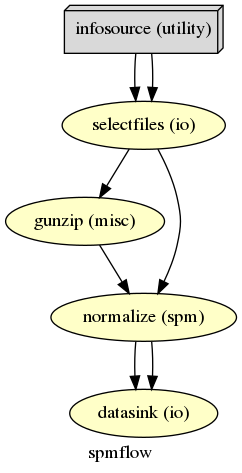

In [16]:
# Create SPM normalization graph
spmflow.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(spmflow.base_dir, 'spmflow', 'graph.png'))

In [17]:
spmflow.run('MultiProc', plugin_args={'n_procs': 4})

190123-16:11:46,899 nipype.workflow INFO:
	 Workflow spmflow settings: ['check', 'execution', 'logging', 'monitoring']
190123-16:11:46,942 nipype.workflow INFO:
	 Running in parallel.
190123-16:11:46,947 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 113.22/113.22, Free processors: 4/4.
190123-16:11:47,24 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.selectfiles" in "/data/EFAT/EFAT_output/HC/workingdir2/spmflow/_fwhm_id_8_subject_id_004/selectfiles".
190123-16:11:47,73 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
190123-16:11:47,29 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.selectfiles" in "/data/EFAT/EFAT_output/HC/workingdir2/spmflow/_fwhm_id_8_subject_id_001/selectfiles".
190123-16:11:47,27 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.selectfiles" in "/data/EFAT/EFAT_output/HC/workingdir2/spmflow/_fwhm_id_8_subject_id_003/selectfiles".
190123-16:11:47,86 nipype.workflow INFO:
	

In [11]:
from nilearn import image, plotting
from os.path import join as opj
%matplotlib inline
# anatimg = '/home/soyeon/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'
anatimg = '/opt/spm12/tpm/TPM.nii'
out_path = '/data/EFAT/EFAT_output/HC/datasink2/norm_spm/sub-003_fwhm8'

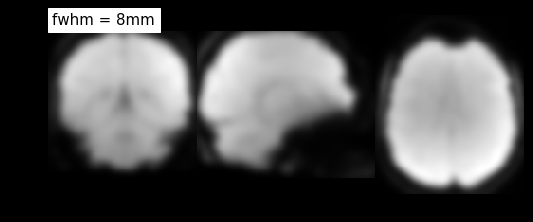

In [12]:
plotting.plot_epi(image.mean_img(opj(out_path, 'wfwhm-8_ssub-003_task-EFAT_bold.nii')),
                  title="fwhm = 8mm", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray');